In [1]:
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style("whitegrid")

import seaborn as sns

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

# from wordcloud import WordCloud

import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools


# Data Collecting 
Web-scraping reviews from Gartner

(1) Likes and dislikes

In [2]:
def get_cards(raw:str)->BeautifulSoup:
    soup = BeautifulSoup(raw)
    cards = soup.find_all("div",{"class":"review"})
    return cards

def get_tag(soup_object:BeautifulSoup)->str:
    tag = soup_object.find("h3",{"class":"likesdislikes-title"}).text
    return tag

def get_review(soup_object:BeautifulSoup) -> str:
    review_text = soup_object.find("div",{"class":"likesdislikes-text"}).text
    return review_text

def get_date(soup_object:BeautifulSoup)->str:
    date_string = soup_object.find("p",{"class":"likesdislikes-date"}).text
    return date_string

def gathering(single_review:BeautifulSoup) -> dict:
    return {
        "name":path,
        "review":get_review(single_review),
        "tag":get_tag(single_review),
        "date":get_date(single_review)               
    }

In [3]:
paths = ["icims","zoho-recruit","greenhouse","jazzHR","CEIPAL","LeverTRM","SmartRecruiters","Freshteam"]

In [4]:
results = []
err_count = 0

for path in paths:
    file = open("../data/"+path+".rtf",'r')
    raw = file.read()
    
    reviews = get_cards(raw)
    for r in reviews:
        try:
            data = gathering(r)
            results.append(data)
        except:
            err_count += 1

In [5]:
df = pd.DataFrame.from_records(results)

In [6]:
df

,name,review,tag,date
0,icims,"Ease of use, breadth of functionality and inte...",likes,"June 14, 2022"
1,icims,A few improvements in the product would be:Add...,dislikes,"May 15, 2022"
2,icims,The Textrecruit and dynamic dashboard reportin...,likes,"May 15, 2022"
3,icims,Customer ServiceNot able to reach a real techn...,dislikes,"December 1, 2022"
4,icims,Notifications EaseIntegrationEasy User Experie...,likes,"June 15, 2022"
...,...,...,...,...
232,Freshteam,1. Integrations to some of the commonly used S...,likes,"May 18, 2022"
233,Freshteam,Pricing is on a higher side for a mid-sized co...,dislikes,"November 23, 2022"
234,Freshteam,Good team management and reviewal procedure fo...,likes,"November 23, 2022"
235,Freshteam,Integration is not performed end to end ...,dislikes,"December 22, 2022"


(2) Star ratings

In [7]:
file = open("../data/ATSoverview.rtf","r")
raw = file.read()

In [8]:
soup = BeautifulSoup(raw)
cards = soup.find_all("div",{"class":"uxd-card"})

In [9]:
def get_cards(raw:str)->BeautifulSoup:
    soup = BeautifulSoup(raw)
    cards = soup.find_all("div",{"class":"uxd-card"})
    return cards

def get_star_rating(soup_object:BeautifulSoup)->str:
    star_rating = soup_object.find("div",{"class":"ratingNumber"}).text
    return float(star_rating)

def get_name(soup_object:BeautifulSoup) -> str:
    name_text = soup_object.find("a",{"class":"card-top-header"}).text
    return name_text

def get_total_ratings(soup_object:BeautifulSoup)->str:
    votes = soup_object.find("a",{"class":"rating-link"}).text
    vote_num = votes.replace(" Ratings","")
    return int(vote_num)

def gathering(single_review:BeautifulSoup) -> dict:
    return {
        "name":get_name(single_review),
        "star_rating":get_star_rating(single_review),
        "rating_votes":get_total_ratings(single_review)
    }

In [10]:
results = []
err_count = 0
    
reviews = get_cards(raw)
for r in reviews:
    try:
        data = gathering(r)
        results.append(data)
    except:
        err_count += 1

In [11]:
df_rate = pd.DataFrame.from_records(results)

In [12]:
df_rate

,name,star_rating,rating_votes
0,iCIMS Talent Cloud,4.0,66
1,Zoho Recruit,4.3,27
2,Greenhouse Recruiting,4.3,15
3,JazzHR,4.3,6
4,CEIPAL Applicant Tracking System,3.8,5
5,Lever TRM,3.5,4
6,SmartRecruiters Talent Acquisition Suite,3.6,3
7,Freshteam,4.0,2
8,Talentpool,4.0,2


In [13]:
df["name"].unique()

array(['icims', 'zoho-recruit', 'greenhouse', 'jazzHR', 'CEIPAL',
       'LeverTRM', 'SmartRecruiters', 'Freshteam'], dtype=object)

In [14]:
def name_change(company):
    company = company.replace('icims','iCIMS Talent Cloud')
    company = company.replace('zoho-recruit','Zoho Recruit')
    company = company.replace('greenhouse','Greenhouse Recruiting')
    company = company.replace('jazzHR','JazzHR')
    company = company.replace('CEIPAL','CEIPAL Applicant Tracking System')
    company = company.replace('LeverTRM','Lever TRM')
    company = company.replace('SmartRecruiters','SmartRecruiters Talent Acquisition Suite')
    return company

In [15]:
df["name"] = df["name"].apply(name_change)

## Preprocessing

In [16]:
from datetime import datetime
from dateutil import parser

In [17]:
df["date"] = df["date"].apply(parser.parse)

In [18]:
df_train = df.sample(frac = 0.8, random_state=123).copy()

In [19]:
df_test = df.drop(df_train.index).copy()

In [20]:
df_train.head()

,name,review,tag,date
108,Greenhouse Recruiting,1. Designing the Personal Welcome Experience f...,likes,2022-06-14
172,CEIPAL Applicant Tracking System,"Job board integration, Power BI that helps wit...",likes,2022-08-03
62,Zoho Recruit,"UI could be better, some buttons are misplaced...",dislikes,2021-03-11
204,SmartRecruiters Talent Acquisition Suite,standard integrations/partnerships with other ...,dislikes,2022-10-14
79,Zoho Recruit,Compact ATS which is powerful and full of grea...,likes,2022-10-28


In [21]:
df_train.tag.value_counts()

likes       95
dislikes    95
Name: tag, dtype: int64

In [22]:
df_test.tag.value_counts()

likes       25
dislikes    22
Name: tag, dtype: int64

In [23]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [24]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [25]:
keep = ['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 
        'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
        "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
        'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
        'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'but','while','against',
        'into','through','before','after','above','below','up','down','in','out','on','off',
        'over','under','again','once','few','more','most','no', 'nor', 'not', 'only','too', 
        'very','don',"don't"]

stop = [word for word in stop if word not in keep]

In [26]:
def clean_tokenizer(msg):
    return [word.lower() for word in tokenizer.tokenize(msg) if word.lower() not in stop]

In [27]:
df_train['tokens'] = df_train['review'].apply(clean_tokenizer)
df_test['tokens'] = df_test['review'].apply(clean_tokenizer)

In [28]:
#0-1 coding

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [29]:
le = LabelEncoder()

In [30]:
df_train['coding'] = df_train[['tag']].apply(le.fit_transform)
df_test['coding'] = df_test[['tag']].apply(le.fit_transform)

In [31]:
# number of words

df_train['num_words'] = df_train['review'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['review'].apply(lambda x: len(str(x).split()))

positive and negative tokens

In [32]:
# Make an empty dictionary
positive_token_dict = {}

# for each positive review
for i in df_train.loc[df_train.coding==1].index:
    # extract tthe tokens
    for token in df_train.tokens[i]:
        # update the dictionary accordingly
        if token in positive_token_dict.keys():
            positive_token_dict[token] = positive_token_dict[token] + 1
        else:
            positive_token_dict[token] = 1

# store them in a dataframe for easy use
positive_token_df = pd.DataFrame({'token':positive_token_dict.keys(),
                         'times_used':positive_token_dict.values()})


In [33]:
# Do the same thing for the negative reviews
negative_token_dict = {}

for i in df_train.loc[df_train.coding==0].index:
    for token in df_train.tokens[i]:
        if token in negative_token_dict.keys():
            negative_token_dict[token] = negative_token_dict[token] + 1
        else:
            negative_token_dict[token] = 1

negative_token_df = pd.DataFrame({'token':negative_token_dict.keys(),
                         'times_used':negative_token_dict.values()})

In [34]:
positive_top100 = set(positive_token_df.sort_values('times_used',ascending=False).head(100).token.values)
negative_top100 = set(negative_token_df.sort_values('times_used',ascending=False).head(100).token.values)

token_list = np.array(list(positive_top100.union(negative_top100)))

print(token_list)

['really' 'zoho' 'onboarding' 'dashboard' '. ...' 'system' 'best' 'list'
 'not' 'out' 'lot' 'notes' 'pricing' 'bit' 'like' 'candidates' 'track'
 'seems' 'in' 'information' 'help' 'hiring' 'once' 'make' 'issues'
 'better' 'well' '.' 'needs' 'tracking' 'need' 'filter' 'email' 'find'
 'difficult' 'us' 'integration' 'manage' 'applicants' 'too' 'service'
 'update' 'but' 'reporting' 'recruiting' 'up' 'job' 'recruiter'
 'workflows' 'team' 'overall' 'icims' '... ...' 'sometimes' 'different'
 'lack' 'interface' 'limited' 'data' 'posting' 'right' 'ease' 'hire'
 'most' 'search' 'integrations' 'candidate' 'product' 'vendor' 'good'
 'view' 'place' '2' 'platform' 'on' 'using' 'solution' '&' 'profile'
 'user' 'simple' 'ability' 'easily' 'interview' 'functionality' 'hr'
 'dislike' '1' 'very' 'tool' 'customer' 'could' 'per' 'no' ',' 'many' '-'
 'experience' 'little' 'resumes' 'feature' 'one' 'see' 'nothing' 'users'
 'love' 'new' 'screening' 'poor' 'ats' 'able' 'free' 'features' 'helps'
 'end' 'always' 

# Classification problem - Linear discriminant analysis, latent semenatic analysis, navie bayes, most used words, most used bigrams, SVD


In [35]:
# Makes a zero matrix of the correct size
X_train = np.zeros((len(df_train),len(token_list)))

# for each review in the training set
for i in range(len(df_train.index)):
    # get the tokens
    for token in list(df_train.tokens)[i]:
        # if the token is in the token_list
        if token in token_list:
            # update accordingly
            X_train[i,token_list==token] = 1
            
# get the training y values
y_train = df_train.coding.values

In [36]:
# use this for your accuracy function
def acc(actual,pred):
    return np.sum(actual==pred)/len(actual)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [38]:
## define functions
# This will take in a dataframe of "words" (note ngrams will work as well)
# and return a list of the unique words, which forms the basis
def get_bow_basis(df,column_name):
    basis_set = []
    
    for i in df.index:
        for word in df[column_name][i]:
            basis_set.append(word)
            
    return np.array(list(set(basis_set)))

## This will take in a basis set and a message's tokens
## and return the bow numpy array (vector)
def get_bow_vector(tokens, basis_set):
    vector = np.zeros(len(basis_set))
    
    for word in tokens:
        # Note this is here for when we look at the test set
        if word in basis_set:
            vector[basis_set == word] = vector[basis_set == word] + 1
        
    return vector

## Takes in a document term word count matrix and
## returns the idfs for the words
def get_idf(doc_term_mat):
    # how many documents are there?
    n_docs = np.shape(doc_term_mat)[0]
    
    # doc_term_mat>0 makes a boolean array of any time the array >0
    # summing along the columns gives the number of documents each term appears in
    return np.log10(n_docs/np.sum(doc_term_mat>0,axis=0))

In [39]:
basis_set = get_bow_basis(df_train,'tokens')

#### TRAINING DATA PREP ####
# this defines an array of zeros with
# number of rows equal to the number of training documents
# and number of columns equal to the number of basis_set words
doc_term_train = np.zeros((len(df_train), len(basis_set)))

# this loops through the documents in the training set
for i in range(len(df_train)):
    # each row of the array is replaced with the bag of words vector
    # for that document
    doc_term_train[i,:] = get_bow_vector(list(df_train.tokens)[i], basis_set)

    
# np.sum(array,axis=1) computes a row sum
# this will give you the word counts for your documents 
# .reshape(-1,1) turns it into a column vector
train_freq = doc_term_train/np.sum(doc_term_train,axis=1).reshape(-1,1)

train_tfidf = train_freq*get_idf(doc_term_train)

#### TEST DATA PREP ####
doc_term_test = np.zeros((len(df_test), len(basis_set)))

for i in range(len(df_test)):
    doc_term_test[i,:] = get_bow_vector(list(df_test.tokens)[i], basis_set)

# test frequency matrix
test_freq = doc_term_test

for i in range(np.shape(test_freq)[0]):
    if np.sum(test_freq[i,:]) > 0:
        test_freq[i,:] = doc_term_test[i,:]/np.sum(doc_term_test[i,:])

test_tfidf = test_freq*get_idf(doc_term_train)

In [40]:
# get the term document matrices for each set
term_doc_train = train_tfidf.transpose()

In [41]:
# Note this may take a bit to run

# apply svd to the training set
T_train,S_train,Dt_train = np.linalg.svd(term_doc_train)

print("Done with svd decomp")

## np.linalg.matrix_rank gives the rank of the matrix
rank = len(S_train)

# We'll now replace all of our SVD output with 
# our lower rank approximation version.
T_train = T_train[:,:rank]
Dt_train = Dt_train[:rank,:]
D_train = Dt_train.transpose()
Sigma_train = np.zeros((rank,rank))

for i in range(len(S_train)):
    Sigma_train[i,i] = S_train[i]

Done with svd decomp


In [42]:
doc_space_train = D_train.dot(Sigma_train)

# Neural networks

(1) Perceptron

In [43]:
from sklearn.decomposition import PCA

In [44]:
# This is done just to improve the speed of fitting the network
# This has nothing to do with making a better model
pca = PCA(n_components = 100)

pca.fit(train_tfidf)

X_train = pca.transform(train_tfidf)
X_test = pca.transform(test_tfidf)

In [45]:
# Perceptron is stored in sklearn.linear_model
from sklearn.linear_model import Perceptron

In [46]:
# We make a perceptron object
perc = Perceptron()

In [47]:
# We fit the object
perc.fit(X_train,y_train)

Perceptron()

In [48]:
train_pred = perc.predict(X_train)

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [50]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

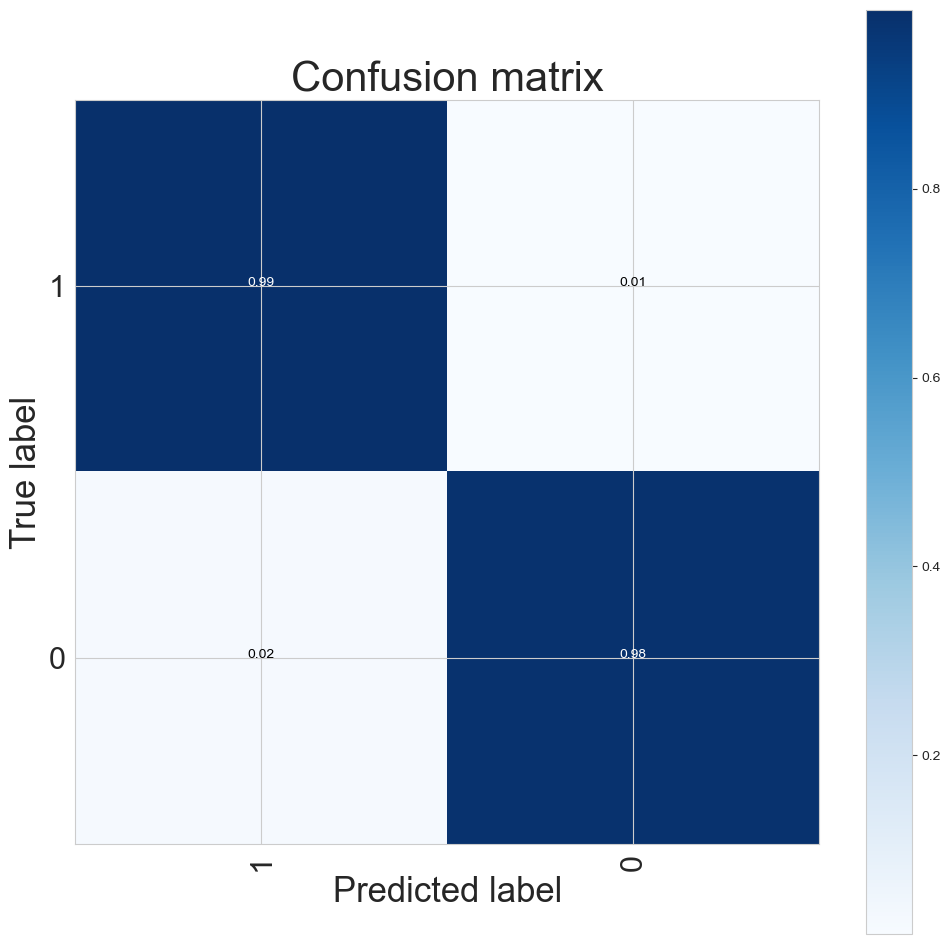

In [51]:
cnf_matrix = confusion_matrix(y_train, train_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.coding.unique(), title="Confusion matrix")
plt.show()

In [52]:
def tpr(actual,pred):
    tp = np.sum((actual==1) & (pred == 1))
    fn = np.sum((actual==1) & (pred == 0))
    return tp/(tp+fn)
    
def fpr(actual,pred):
    fp = np.sum((actual == 0) & (pred == 1))
    tn = np.sum((actual == 0) & (pred == 0))
    return fp/(fp+tn)

def acc(actual,pred):
    return np.sum(actual==pred)/len(actual)

In [53]:
train_pred = perc.predict(X_train)

print("The training tpr is",tpr(y_train,train_pred))
print("The training fpr is",fpr(y_train,train_pred))
print("The training accuracy is",acc(y_train,train_pred))

The training tpr is 0.9789473684210527
The training fpr is 0.010526315789473684
The training accuracy is 0.9842105263157894


(2) Multilayer Networks

In [54]:
# import MLPClassifier
from sklearn.neural_network import MLPClassifier

In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(500,),max_iter=1000)

mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(500,), max_iter=1000)

In [56]:
train_pred = mlp.predict(X_train)

print("The training tpr is",tpr(y_train,train_pred))
print("The training fpr is",fpr(y_train,train_pred))
print("The training accuracy is",acc(y_train,train_pred))

The training tpr is 1.0
The training fpr is 0.0
The training accuracy is 1.0


In [57]:
y_test=df_test.coding.values

In [58]:
test_pred = mlp.predict(X_test)

print("The test tpr is",tpr(y_test,test_pred))
print("The test fpr is",fpr(y_test,test_pred))
print("The test accuracy is",acc(y_test,test_pred))

The test tpr is 0.72
The test fpr is 0.2727272727272727
The test accuracy is 0.723404255319149


(3) Keras

In [59]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [60]:
model = models.Sequential()

In [61]:
n = X_train.shape[1]

In [62]:
model.add(layers.Dense(16, activation='relu', input_shape=(n,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [63]:
model.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

In [64]:
## I now fit the model, and store the training history
history = model.fit(X_train,
                       y_train,
                       epochs = 10,
                       batch_size = 100,
                       validation_data = (X_test, y_test))

Epoch 1/10
1/2 [==============>...............] - ETA: 0s - loss: 0.6945 - accuracy: 0.5100

2023-06-07 22:53:01.983878: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 67ms/step - loss: 0.6932 - accuracy: 0.5158 - val_loss: 0.6926 - val_accuracy: 0.5745
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.5368 - val_loss: 0.6920 - val_accuracy: 0.5532
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6910 - accuracy: 0.5211 - val_loss: 0.6913 - val_accuracy: 0.5532
Epoch 4/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6904 - accuracy: 0.5368 - val_loss: 0.6909 - val_accuracy: 0.5532
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6893 - accuracy: 0.5474 - val_loss: 0.6904 - val_accuracy: 0.5532
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6886 - accuracy: 0.5316 - val_loss: 0.6900 - val_accuracy: 0.5532
Epoch 7/10
2/2 [==============================] - 0s 11ms/step - loss: 0.6878 - accuracy: 0.5474 - val_loss: 0.6895 - val_accuracy: 0.5532
Epoch 8/10
2/2 [======================

In [65]:
history_dict = history.history

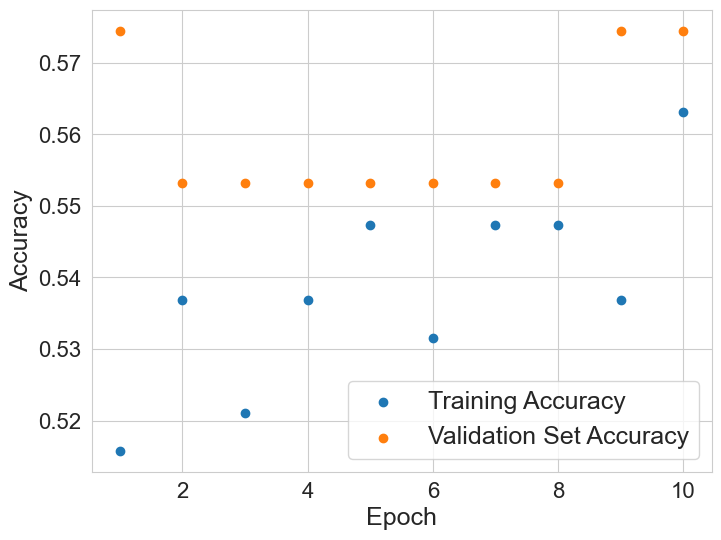

In [66]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,11), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,11), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

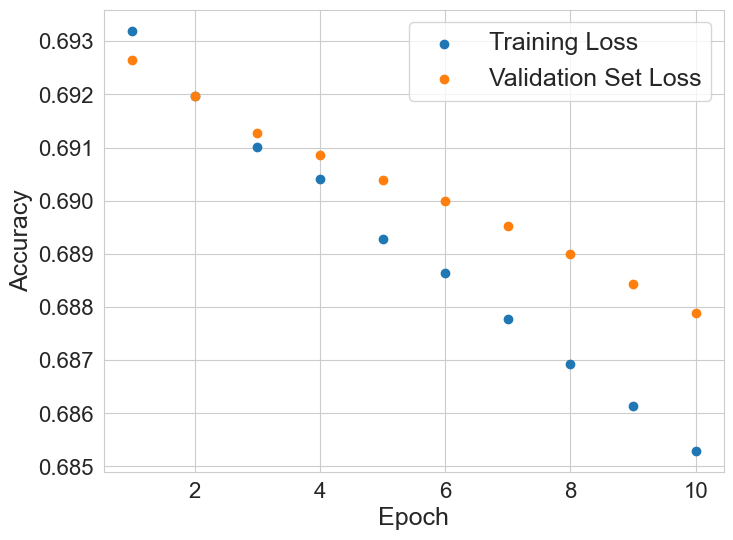

In [67]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,11), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,11), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

# Word2Vec

In [68]:
from keras.datasets import imdb

In [69]:
n = 10000
(imdb_train,y_train_imdb), (imdb_test,y_test_imdb) = imdb.load_data(num_words=n, 
                                                                                seed=440,
                                                                                index_from=3)

# word_index is a dictionary that maps each word to it's index
imdb_word_index = imdb.get_word_index()

# We now adjust the indices according to the coding presented above
imdb_word_index = {key:(value+3) for key,value in imdb_word_index.items()}

imdb_word_index["<PAD>"] = 0
imdb_word_index["<START>"] = 1
imdb_word_index["<UNKNOWN WORD>"] = 2
imdb_word_index["<UNUSED WORD>"] = 3

imdb_reverse_index = dict([(value,key) for (key,value) in imdb_word_index.items()])

In [70]:
from keras.preprocessing import sequence

In [71]:
window_size = 2

In [72]:
### You Code Here
positive_skip_grams_71, _ = sequence.skipgrams(
                                  imdb_train[71], 
                                  vocabulary_size=n,
                                  window_size=window_size,
                                  negative_samples=0)

print("The sentence was:")
print(" ".join([imdb_reverse_index[i] for i in imdb_train[71]]))

print("######################")

print("The skip-grams are:")
for item in positive_skip_grams_71:
    print(imdb_reverse_index[item[0]],imdb_reverse_index[item[1]])

The sentence was:
<START> i watched this movie on march 21 this year must say disappointment but much better than <UNKNOWN WORD> plot is hackneyed tells about <UNKNOWN WORD> who lives with his father wife and his little brother the movie opens when he saves a bride anyway <UNKNOWN WORD> <UNKNOWN WORD> makes a plot to kill his young brother he makes a plan by sending few man they come to a school <UNKNOWN WORD> to be <UNKNOWN WORD> friends kill that kid his father throws him out of the house then later comes back he and <UNKNOWN WORD> go to <UNKNOWN WORD> to find him sunny gives a good performance <UNKNOWN WORD> was annoying at best <UNKNOWN WORD> is wasted <UNKNOWN WORD> did good <UNKNOWN WORD> was wasted <UNKNOWN WORD> was wasted but looked cute the kid which played <UNKNOWN WORD> brother in the movie was cute too sad he had to get his character killed the girl was cute but was annoying the other kid did good <UNKNOWN WORD> did good <UNKNOWN WORD> was adequate <UNKNOWN WORD> and <UNKN

In [73]:
skipgrams = [('king','kingdom'),('queen','kingdom'),('king','palace'),('queen','palace'),('king','royal'),
            ('queen','royal'),('king','George'),('queen','Mary'),('man','rice'),('woman','rice'),
            ('man','farmer'),('woman','farmer'),('man','house'),('woman','house'),('man','George'),
            ('woman','Mary')]

word_index = {'George':0, 'Mary':1, 'farmer':2, 'house':3, 'kingdom':4,
                 'king':5, 'man':6, 'palace':7, 'queen':8, 'rice':9, 'royal':10,
                 'woman':11}

skipgrams = [(word_index[gram[0]],word_index[gram[1]]) for gram in skipgrams]

reverse_index = {i:word for word,i in word_index.items()}

In [74]:
import numpy as np

In [75]:
X = np.zeros((len(word_index.keys()),len(skipgrams)))
y = np.zeros((len(word_index.keys()),len(skipgrams)))

In [76]:
for j in range(len(skipgrams)):
    gram = skipgrams[j]
    X[gram[1],j] = 1
    y[gram[0],j] = 1

In [77]:
import tensorflow as tf

In [78]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [79]:
### You code

# we first make an empty model
# Sequential means we'll make a group
# of a linear stack of layers
model = models.Sequential()

# Hidden Layer
model.add(layers.Dense(5, input_shape=(len(word_index.keys()),)))

# output Layer
model.add(layers.Dense(len(word_index.keys()), activation='softmax'))

In [80]:
model.compile(optimizer = 'SGD',
                 loss = 'categorical_crossentropy')

In [81]:
model.fit(X.transpose(),
           y.transpose(),
           epochs = 500,
           batch_size = 1)

Epoch 1/500
16/16 [==============================] - 0s 379us/step - loss: 2.4851
Epoch 2/500
16/16 [==============================] - 0s 407us/step - loss: 2.4464
Epoch 3/500
16/16 [==============================] - 0s 412us/step - loss: 2.4090
Epoch 4/500
16/16 [==============================] - 0s 443us/step - loss: 2.3727
Epoch 5/500
16/16 [==============================] - 0s 368us/step - loss: 2.3374
Epoch 6/500
16/16 [==============================] - 0s 357us/step - loss: 2.3031
Epoch 7/500
16/16 [==============================] - 0s 414us/step - loss: 2.2695
Epoch 8/500
16/16 [==============================] - 0s 390us/step - loss: 2.2366
Epoch 9/500
16/16 [==============================] - 0s 388us/step - loss: 2.2045
Epoch 10/500
16/16 [==============================] - 0s 337us/step - loss: 2.1727
Epoch 11/500
16/16 [==============================] - 0s 342us/step - loss: 2.1416
Epoch 12/500
16/16 [==============================] - 0s 420us/step - loss: 2.1109
Epoch 13/500


16/16 [==============================] - 0s 300us/step - loss: 0.8684
Epoch 100/500
16/16 [==============================] - 0s 303us/step - loss: 0.8661
Epoch 101/500
16/16 [==============================] - 0s 317us/step - loss: 0.8638
Epoch 102/500
16/16 [==============================] - 0s 310us/step - loss: 0.8610
Epoch 103/500
16/16 [==============================] - 0s 304us/step - loss: 0.8581
Epoch 104/500
16/16 [==============================] - 0s 322us/step - loss: 0.8559
Epoch 105/500
16/16 [==============================] - 0s 313us/step - loss: 0.8518
Epoch 106/500
16/16 [==============================] - 0s 318us/step - loss: 0.8504
Epoch 107/500
16/16 [==============================] - 0s 301us/step - loss: 0.8488
Epoch 108/500
16/16 [==============================] - 0s 330us/step - loss: 0.8467
Epoch 109/500
16/16 [==============================] - 0s 326us/step - loss: 0.8443
Epoch 110/500
16/16 [==============================] - 0s 324us/step - loss: 0.8419
Epoch 

16/16 [==============================] - 0s 336us/step - loss: 0.7681
Epoch 197/500
16/16 [==============================] - 0s 308us/step - loss: 0.7676
Epoch 198/500
16/16 [==============================] - 0s 306us/step - loss: 0.7662
Epoch 199/500
16/16 [==============================] - 0s 304us/step - loss: 0.7654
Epoch 200/500
16/16 [==============================] - 0s 299us/step - loss: 0.7668
Epoch 201/500
16/16 [==============================] - 0s 330us/step - loss: 0.7659
Epoch 202/500
16/16 [==============================] - 0s 384us/step - loss: 0.7654
Epoch 203/500
16/16 [==============================] - 0s 329us/step - loss: 0.7653
Epoch 204/500
16/16 [==============================] - 0s 329us/step - loss: 0.7647
Epoch 205/500
16/16 [==============================] - 0s 340us/step - loss: 0.7643
Epoch 206/500
16/16 [==============================] - 0s 311us/step - loss: 0.7627
Epoch 207/500
16/16 [==============================] - 0s 308us/step - loss: 0.7642
Epoch 

16/16 [==============================] - 0s 292us/step - loss: 0.7516
Epoch 294/500
16/16 [==============================] - 0s 331us/step - loss: 0.7515
Epoch 295/500
16/16 [==============================] - 0s 327us/step - loss: 0.7509
Epoch 296/500
16/16 [==============================] - 0s 357us/step - loss: 0.7510
Epoch 297/500
16/16 [==============================] - 0s 325us/step - loss: 0.7524
Epoch 298/500
16/16 [==============================] - 0s 358us/step - loss: 0.7511
Epoch 299/500
16/16 [==============================] - 0s 332us/step - loss: 0.7508
Epoch 300/500
16/16 [==============================] - 0s 321us/step - loss: 0.7502
Epoch 301/500
16/16 [==============================] - 0s 316us/step - loss: 0.7512
Epoch 302/500
16/16 [==============================] - 0s 326us/step - loss: 0.7513
Epoch 303/500
16/16 [==============================] - 0s 288us/step - loss: 0.7493
Epoch 304/500
16/16 [==============================] - 0s 310us/step - loss: 0.7517
Epoch 

16/16 [==============================] - 0s 340us/step - loss: 0.7468
Epoch 391/500
16/16 [==============================] - 0s 322us/step - loss: 0.7470
Epoch 392/500
16/16 [==============================] - 0s 361us/step - loss: 0.7467
Epoch 393/500
16/16 [==============================] - 0s 306us/step - loss: 0.7463
Epoch 394/500
16/16 [==============================] - 0s 326us/step - loss: 0.7461
Epoch 395/500
16/16 [==============================] - 0s 333us/step - loss: 0.7467
Epoch 396/500
16/16 [==============================] - 0s 325us/step - loss: 0.7467
Epoch 397/500
16/16 [==============================] - 0s 298us/step - loss: 0.7470
Epoch 398/500
16/16 [==============================] - 0s 322us/step - loss: 0.7471
Epoch 399/500
16/16 [==============================] - 0s 306us/step - loss: 0.7463
Epoch 400/500
16/16 [==============================] - 0s 298us/step - loss: 0.7443
Epoch 401/500
16/16 [==============================] - 0s 305us/step - loss: 0.7463
Epoch 

16/16 [==============================] - 0s 322us/step - loss: 0.7432
Epoch 488/500
16/16 [==============================] - 0s 328us/step - loss: 0.7458
Epoch 489/500
16/16 [==============================] - 0s 342us/step - loss: 0.7443
Epoch 490/500
16/16 [==============================] - 0s 326us/step - loss: 0.7449
Epoch 491/500
16/16 [==============================] - 0s 320us/step - loss: 0.7438
Epoch 492/500
16/16 [==============================] - 0s 344us/step - loss: 0.7447
Epoch 493/500
16/16 [==============================] - 0s 315us/step - loss: 0.7450
Epoch 494/500
16/16 [==============================] - 0s 341us/step - loss: 0.7426
Epoch 495/500
16/16 [==============================] - 0s 314us/step - loss: 0.7451
Epoch 496/500
16/16 [==============================] - 0s 312us/step - loss: 0.7442
Epoch 497/500
16/16 [==============================] - 0s 306us/step - loss: 0.7448
Epoch 498/500
16/16 [==============================] - 0s 328us/step - loss: 0.7442
Epoch 

ValueError: x and y must be the same size

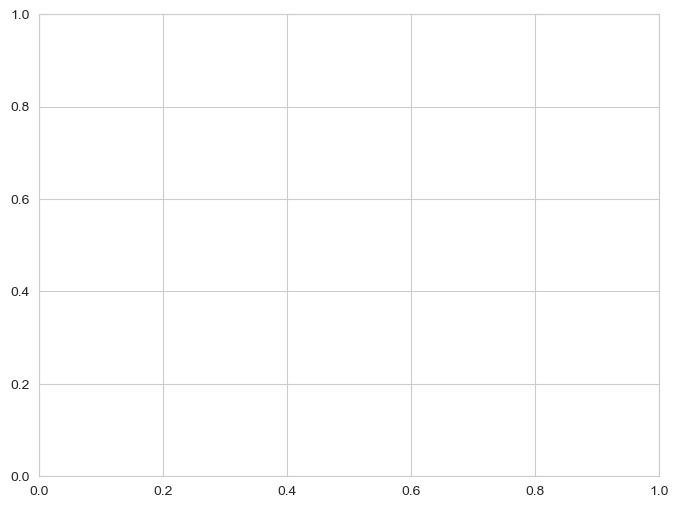

In [82]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,21), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,21), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()